GlucForecast v.1

In [28]:
import pandas as pd
import numpy as np


data_from_cap = pd.read_csv("/content/adolescent#001-train-processed.csv")
"""
'Time' : the timestamp of the data point, indicating when the observation was recorded. It is in the format 'MM/DD/YYYY HH:mm'
'BG' :  the blood glucose level at a particular time. mg/dL
"""
data_from_cap.head(20)

,Time,BG,Date,Hour
0,2019-05-01 00:00:00,149.020000,2019-05-01,0
1,2019-05-01 00:03:00,149.020000,2019-05-01,0
2,2019-05-01 00:06:00,149.020000,2019-05-01,0
3,2019-05-01 00:09:00,149.020000,2019-05-01,0
4,2019-05-01 00:12:00,149.020000,2019-05-01,0
5,2019-05-01 00:15:00,149.020000,2019-05-01,0
6,2019-05-01 00:18:00,149.020000,2019-05-01,0
7,2019-05-01 00:21:00,149.020000,2019-05-01,0
8,2019-05-01 00:24:00,149.020001,2019-05-01,0
9,2019-05-01 00:27:00,149.020002,2019-05-01,0


In [11]:
data_from_cap.describe()

,BG,Hour
count,36480.000000,36480.000000
mean,147.041818,11.500000
std,22.482711,6.922281
min,84.908195,0.000000
25%,133.512218,5.750000
50%,144.624992,11.500000
75%,163.178230,17.250000
max,223.286543,23.000000


In [16]:
data_from_cap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36480 entries, 0 to 36479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    36480 non-null  object 
 1   BG      36480 non-null  float64
 2   Date    36480 non-null  object 
 3   Hour    36480 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


NaN values detection

In [18]:
data_from_cap.isnull().sum()

Time    0
BG      0
Date    0
Hour    0
dtype: int64

Outliers Dteetction

In [19]:
def detect_outliers(data,column,q1=.25,q3=.75):
    quantile1 = data[column].quantile(q1)
    quantile3 = data[column].quantile(q3)
    IQR =  quantile3 - quantile1
    up_limit = quantile3 + (IQR*1.5)
    low_limit = quantile1 - (IQR*1.5)

    return up_limit, low_limit

detect_outliers(data_from_cap,'BG')

(207.67724896250004, 89.01319926249997)

In [29]:
# Convert Date column to datetime
data_from_cap.Time = pd.to_datetime(data_from_cap.Time,dayfirst=True).dt.strftime('%d-%m-%Y %H:%M')
data_from_cap.BG = data_from_cap.BG.astype(int)
data_from_cap_processed = data_from_cap.iloc[:,:2]
data_from_cap_processed.head(20)

,Time,BG
0,01-05-2019 00:00,149
1,01-05-2019 00:03,149
2,01-05-2019 00:06,149
3,01-05-2019 00:09,149
4,01-05-2019 00:12,149
5,01-05-2019 00:15,149
6,01-05-2019 00:18,149
7,01-05-2019 00:21,149
8,01-05-2019 00:24,149
9,01-05-2019 00:27,149


data visualisation

In [30]:
corr_data_from_cap_processed = data_from_cap.corr()
corr_data_from_cap_processed

<ipython-input-30-630657e6bb8c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_data_from_cap_processed = data_from_cap.corr()


,BG,Hour
BG,1.000000,0.227362
Hour,0.227362,1.000000


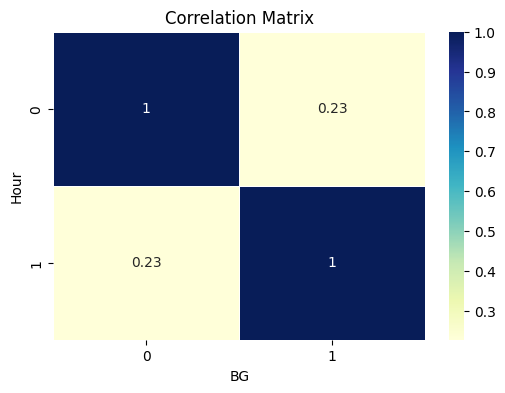

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define the correlation matrix
correlation_matrix = np.array(corr_data_from_cap_processed)

# Create a heatmap plot
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True,linewidths=.5,cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.xlabel('BG')
plt.ylabel('Hour')
plt.show()

GlucForecast v.2

In [1]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statistics
import tensorflow as tf

In [2]:
# Cell 2

# Set initial variables
print('\nBegin Part 2 of 19 - Set variables\n')

# Set train_YN to Y if actual training needs to be done.  If just runnin against the test set,
# then set to N.
train_YN = 'Y'

# Set initial_path
initial_path = '/home/pace/glucose/data_files/adolescent-2160-0-Dexcom-Cozmo-Basal/'

input_train_file_name_prefix = 'adolescent#001'
input_test_file_name_prefix = 'adolescent#001'

# Determine if data should be plotted
plot_data = 'Y' # Values are Y or N

# Set processed_train_file_name and processed_test_file_name
processed_train_file_name = input_train_file_name_prefix + '-train-processed.csv'
processed_test_file_name = input_test_file_name_prefix + '-test-processed.csv'

# Set value of how many records to use depending on training set size
# If training set size is 2160 hours, use 1824
train_record_number = 1824

# Set value of how many records to use depending on test set size
# If training set size is 2160 hours, use 396
test_record_number = 396

# Number of epochs to run
num_epochs = 100
# Batch size
training_batch_size = 32
# Set initial loss value to 0.  This is needed for printing the graph if training is not run.
loss = 0

# Model file
model_file = 'Model_Metadata.h5'



Begin Part 2 of 19 - Set variables



In [3]:
test_df = pd.read_csv("/content/adolescent#001-test-processed.csv", index_col=False)
train_df = pd.read_csv("/content/adolescent#001-train-processed.csv", index_col=False)

print('\nFinished Part 6 of 19 - Open and read processed files.  Ready to move to next cell.')


Finished Part 6 of 19 - Open and read processed files.  Ready to move to next cell.


In [4]:
# Cell 4

# Group by date
print('\nBegin Part 7 of 19 - Group by date\n')

# Group BG levels by Date and Hour in both df.  means is a Series object.
train_means = train_df['BG'].groupby([train_df['Date'], train_df['Hour']]).mean()
print('Finished grouping by date for train')

test_means = test_df['BG'].groupby([test_df['Date'], test_df['Hour']]).mean()
print('Finished grouping by date for test')

print('\nFinished Part 7 of 19 - Group by date.  Ready to move to next cell.')


Begin Part 7 of 19 - Group by date

Finished grouping by date for train
Finished grouping by date for test

Finished Part 7 of 19 - Group by date.  Ready to move to next cell.


In [22]:
train_means

Date        Hour
2019-05-01  0       149.020011
            1       149.020366
            2       149.021754
            3       149.024030
            4       149.026563
                       ...    
2019-07-15  19      130.186227
            20      165.031350
            21      192.444889
            22      181.034648
            23      159.858921
Name: BG, Length: 1824, dtype: float64


Begin Part 8 of 19 - Plot train and test data



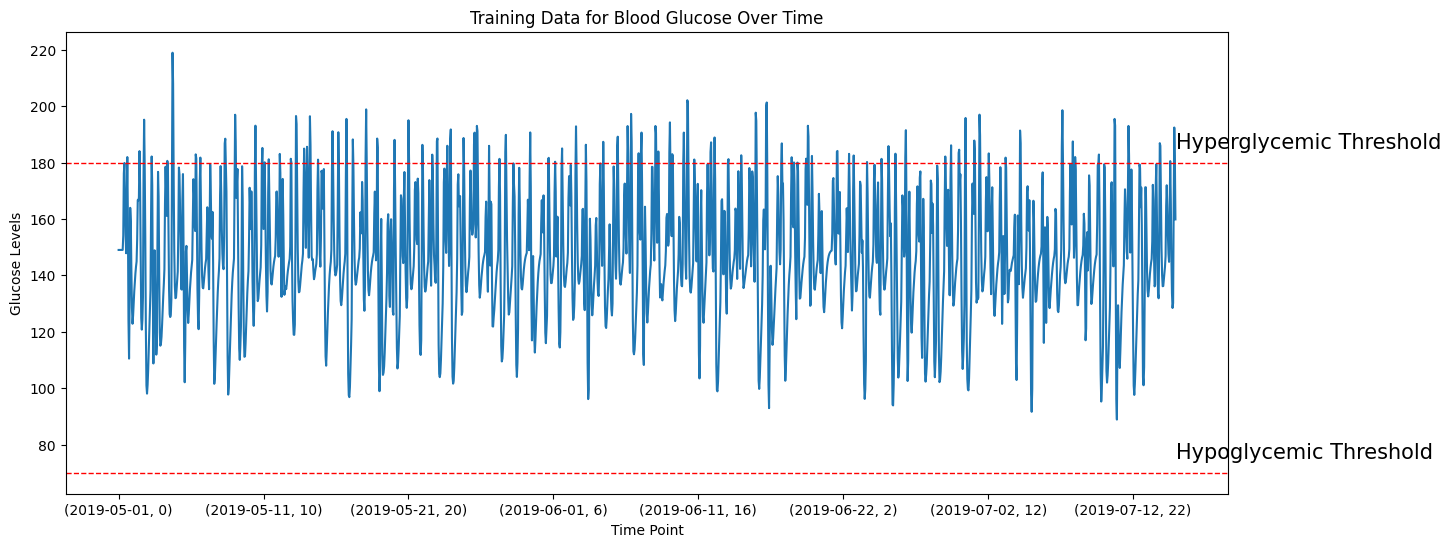

Beginning date for train_means
Date        Hour
2019-05-01  0       149.020011
Name: BG, dtype: float64
Ending date for train_means
Date        Hour
2019-07-15  23      159.858921
Name: BG, dtype: float64


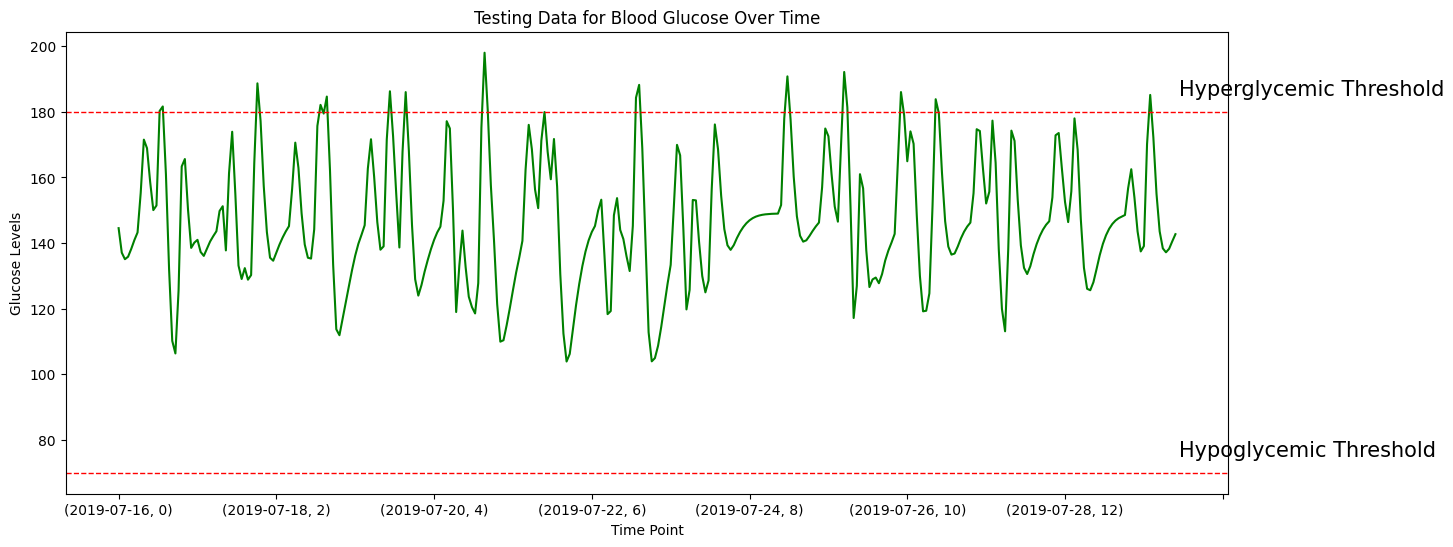

Beginning date for test_means
Date        Hour
2019-07-16  0       144.555197
Name: BG, dtype: float64
Ending date for test_means
Date        Hour
2019-07-29  23      142.72328
Name: BG, dtype: float64

Finished Part 8 of 19 - Plot train and test data.  Ready to move to next cell.


In [43]:
# Cell 5

# Plot test and train data
print('\nBegin Part 8 of 19 - Plot train and test data\n')

# Plot means
if(plot_data == 'Y'):
  plt.figure(figsize=(15,6))
  train_means.plot(kind='line', title='Training Data for Blood Glucose Over Time')
  plt.xlabel('Time Point')
  plt.ylabel('Glucose Levels')
  plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
  plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
  plt.text(len(train_means),185,'Hyperglycemic Threshold',size=15)
  plt.text(len(train_means),75,'Hypoglycemic Threshold',size=15)
  plt.show()

  print('Beginning date for train_means')
  print(train_means[[0]])
  print('Ending date for train_means')
  print(train_means[[len(train_means) - 1]])

if(plot_data == 'Y'):
  plt.figure(figsize=(15,6))
  test_means.plot(kind='line', color='green', title='Testing Data for Blood Glucose Over Time' )
  plt.xlabel('Time Point')
  plt.ylabel('Glucose Levels')
  plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
  plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
  plt.text(len(test_means),185,'Hyperglycemic Threshold',size=15)
  plt.text(len(test_means),75,'Hypoglycemic Threshold',size=15)
  plt.show()

  print('Beginning date for test_means')
  print(test_means[[0]])
  print('Ending date for test_means')
  print(test_means[[len(test_means) - 1]])

print('\nFinished Part 8 of 19 - Plot train and test data.  Ready to move to next cell.')

In [5]:
# Cell 6

# Add each element of train_means to train_glucose_df

print('Begin adding elements to train_glucose_df')
train_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, len(train_means)):
  temp_date = train_means.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ' ' + str(temp_date[1])
  train_glucose_level = train_means[[i][0]]
  train_glucose_df.loc[len(train_glucose_df)] = [temp_date_hour, train_glucose_level]
print('Finished adding elements to train_glucose_df')

print('Begin adding elements to test_glucose_df')
test_glucose_df = pd.DataFrame(columns=['Date_Hour', 'Glucose_Level'])
for i in range(0, len(test_means)):
  temp_date = test_means.index[[i][0]]
  temp_date_hour = str(temp_date[0]) + ' ' + str(temp_date[1])
  test_glucose_level = test_means[[i][0]]
  test_glucose_df.loc[len(test_glucose_df)] = [temp_date_hour, test_glucose_level]
print('Finished adding elements to test_glucose_df')

train_glucose_df

Begin adding elements to train_glucose_df
Finished adding elements to train_glucose_df
Begin adding elements to test_glucose_df
Finished adding elements to test_glucose_df


,Date_Hour,Glucose_Level
0,2019-05-01 0,149.020011
1,2019-05-01 1,149.020366
2,2019-05-01 2,149.021754
3,2019-05-01 3,149.024030
4,2019-05-01 4,149.026563
...,...,...
1819,2019-07-15 19,130.186227
1820,2019-07-15 20,165.031350
1821,2019-07-15 21,192.444889
1822,2019-07-15 22,181.034648


In [47]:
train_glucose_df

,Date_Hour,Glucose_Level
0,2019-05-01 0,149.020011
1,2019-05-01 1,149.020366
2,2019-05-01 2,149.021754
3,2019-05-01 3,149.024030
4,2019-05-01 4,149.026563
...,...,...
1819,2019-07-15 19,130.186227
1820,2019-07-15 20,165.031350
1821,2019-07-15 21,192.444889
1822,2019-07-15 22,181.034648


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Begin LSTM
# Scale training set
print('\nBegin Part 10 of 19 - Scale training set\n')

glucose_training_set = train_glucose_df.iloc[:,1:2].values
# Feature scaling
scaler = MinMaxScaler(feature_range = (0,1))
glucose_training_set_scaled = scaler.fit_transform(glucose_training_set)

glucose_training_set_scaled


Begin Part 10 of 19 - Scale training set



array([[0.46237115],
       [0.46237388],
       [0.46238454],
       ...,
       [0.79607948],
       [0.70839489],
       [0.54566521]])

In [7]:
# Cell 8

# Begin prepping training set
print('\nBegin Part 11 of 19 - Prep training set\n')

features_set = []
labels = []

for i in range(60, train_record_number):
    # Original
    #features_set.append(glucose_training_set_scaled[i-60:i, 0])
    # Updated (Get values from 0-59 to use as the value to predict 60)
    features_set.append(glucose_training_set_scaled[i-60:i, 0])
    labels.append(glucose_training_set_scaled[i, 0])


features_set


Begin Part 11 of 19 - Prep training set



[array([0.46237115, 0.46237388, 0.46238454, 0.46240204, 0.4624215 ,
        0.46243933, 0.46245404, 0.46246547, 0.50143474, 0.67105334,
        0.69948195, 0.60556019, 0.5074839 , 0.45335768, 0.59041184,
        0.71556246, 0.54856159, 0.27014744, 0.16618671, 0.33372087,
        0.57719091, 0.54023845, 0.40932501, 0.3046622 , 0.26119744,
        0.28375763, 0.31987582, 0.35015165, 0.37646133, 0.39893077,
        0.41701988, 0.43085107, 0.49105487, 0.59849565, 0.5970286 ,
        0.60527721, 0.73176053, 0.64250304, 0.44254657, 0.27705803,
        0.24518323, 0.27134731, 0.33491811, 0.66509735, 0.81741422,
        0.69165668, 0.49883896, 0.24486809, 0.09292575, 0.07075618,
        0.09476233, 0.1364885 , 0.19089589, 0.24813139, 0.30037257,
        0.3537575 , 0.56473299, 0.71716345, 0.63869841, 0.35615796]),
 array([0.46237388, 0.46238454, 0.46240204, 0.4624215 , 0.46243933,
        0.46245404, 0.46246547, 0.50143474, 0.67105334, 0.69948195,
        0.60556019, 0.5074839 , 0.45335768, 0.

In [8]:
# Cell 9

# Reshape training set
print('\nBegin Part 12 of 19 - Reshape training set\n')

features_set, labels = np.array(features_set), np.array(labels)

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

features_set


Begin Part 12 of 19 - Reshape training set



array([[[0.46237115],
        [0.46237388],
        [0.46238454],
        ...,
        [0.71716345],
        [0.63869841],
        [0.35615796]],

       [[0.46237388],
        [0.46238454],
        [0.46240204],
        ...,
        [0.63869841],
        [0.35615796],
        [0.1529598 ]],

       [[0.46238454],
        [0.46240204],
        [0.4624215 ],
        ...,
        [0.35615796],
        [0.1529598 ],
        [0.35401216]],

       ...,

       [[0.69558251],
        [0.68581013],
        [0.57899321],
        ...,
        [0.30420479],
        [0.31763866],
        [0.58541392]],

       [[0.68581013],
        [0.57899321],
        [0.63258068],
        ...,
        [0.31763866],
        [0.58541392],
        [0.79607948]],

       [[0.57899321],
        [0.63258068],
        [0.52872582],
        ...,
        [0.58541392],
        [0.79607948],
        [0.70839489]]])

In [9]:
# Build LSTM model

if train_YN == 'Y':
  print('\nBegin Part 13 of 19 - Build LSTM\n')

  model = Sequential()

  model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  model.summary()




Begin Part 13 of 19 - Build LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)       

In [10]:
# Cell 11

# Create model
# This only needs to be done if train_YN == Y
if train_YN == 'Y':

  print('\nBegin Part 14 of 19 - Create model\n')
  from keras.callbacks import EarlyStopping

  # Patient early stopping
  es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

  history = model.fit(features_set, labels, epochs = num_epochs, batch_size = training_batch_size, callbacks = [es])

  loss = model.evaluate(features_set, labels, verbose=0)
  print('\nUnscaled Loss = ' + str(loss))


  #######
  # Save model
  model.save(model_file)



Begin Part 14 of 19 - Create model

Epoch 1/100
56/56 [==============================] - 10s 15ms/step - loss: 0.0474
Epoch 2/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0319
Epoch 3/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0311
Epoch 4/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0312
Epoch 5/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0306
Epoch 6/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0327
Epoch 7/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0306
Epoch 8/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0301
Epoch 9/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0298
Epoch 10/100
56/56 [==============================] - 1s 18ms/step - loss: 0.0285
Epoch 11/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0282
Epoch 12/100
56/56 [==============================] - 1s 13ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# Cell 12

# Concat train and test to be able to do run testing
print('\nBegin Part 15 of 19 - Concat train and test\n')

glucose_total = pd.DataFrame(columns=['Glucose_Level'])

glucose_total = pd.concat((train_glucose_df['Glucose_Level'], test_glucose_df['Glucose_Level']), axis=0)

glucose_total


Begin Part 15 of 19 - Concat train and test



0      149.020011
1      149.020366
2      149.021754
3      149.024030
4      149.026563
          ...    
331    138.395591
332    137.192480
333    138.267193
334    140.548088
335    142.723280
Name: Glucose_Level, Length: 2160, dtype: float64

In [12]:
# Cell 13

#Reshape test shape
print('\nBegin Part 16 of 19 - Reshape test set\n')

test_inputs = glucose_total[len(train_glucose_df) - 60:].values

test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_inputs


Begin Part 16 of 19 - Reshape test set



array([[0.63258068],
       [0.52872582],
       [0.30195395],
       [0.11574054],
       [0.09354272],
       [0.1430971 ],
       [0.34490973],
       [0.63340147],
       [0.63300101],
       [0.5087484 ],
       [0.40527273],
       [0.35247433],
       [0.33575881],
       [0.35038412],
       [0.37532353],
       [0.39676095],
       [0.41394265],
       [0.42756432],
       [0.43798776],
       [0.4856746 ],
       [0.63986608],
       [0.59728156],
       [0.45453922],
       [0.36303066],
       [0.36679697],
       [0.63513466],
       [0.69596962],
       [0.56922506],
       [0.43343421],
       [0.34260673],
       [0.33065169],
       [0.47665482],
       [0.75339288],
       [0.74630951],
       [0.59723644],
       [0.46665438],
       [0.39358555],
       [0.36350642],
       [0.36410584],
       [0.38239614],
       [0.40140523],
       [0.41691104],
       [0.44576991],
       [0.58273179],
       [0.63870837],
       [0.57931389],
       [0.50292442],
       [0.451

In [13]:
# Cell 14

#Prep test set
print('\nBegin Part 17 of 19 - Prep test set\n')

test_features = []
for i in range(60, test_record_number):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

test_features


Begin Part 17 of 19 - Prep test set



array([[[0.63258068],
        [0.52872582],
        [0.30195395],
        ...,
        [0.79607948],
        [0.70839489],
        [0.54566521]],

       [[0.52872582],
        [0.30195395],
        [0.11574054],
        ...,
        [0.70839489],
        [0.54566521],
        [0.42806027]],

       [[0.30195395],
        [0.11574054],
        [0.09354272],
        ...,
        [0.54566521],
        [0.42806027],
        [0.37063326]],

       ...,

       [[0.65564744],
        [0.56659579],
        [0.48577184],
        ...,
        [0.42040349],
        [0.38072538],
        [0.3714798 ]],

       [[0.56659579],
        [0.48577184],
        [0.51341247],
        ...,
        [0.38072538],
        [0.3714798 ],
        [0.37973867]],

       [[0.48577184],
        [0.51341247],
        [0.67996387],
        ...,
        [0.3714798 ],
        [0.37973867],
        [0.39726673]]])

In [14]:
# Cell 15

#Predictions
print('\nBegin Part 18 of 19 - Predictions\n')


model = load_model(model_file)

predictions = model.predict(test_features)

#Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

actual_predicted_difference_list = []

for i in range(0,len(predictions)):
    print('\nActual value for ' + str(test_glucose_df.loc[i,'Date_Hour']) + ' = ' + str(test_glucose_df.loc[i,'Glucose_Level']))
    print('Predicted value = {0}'.format(predictions[i,0]))

    # Calculate mean square error
    actual_predicted_difference_list.append((predictions[i,0] - test_glucose_df.loc[i,'Glucose_Level']) ** 2)

mean_square = statistics.mean(actual_predicted_difference_list)
print('Mean square error = ' + str(mean_square))





Begin Part 18 of 19 - Predictions

11/11 [==============================] - 1s 8ms/step

Actual value for 2019-07-16 0 = 144.55519697
Predicted value = 142.98321533203125

Actual value for 2019-07-16 1 = 137.082321445
Predicted value = 137.42518615722656

Actual value for 2019-07-16 2 = 135.09097308
Predicted value = 136.77865600585938

Actual value for 2019-07-16 3 = 135.84689816999997
Predicted value = 138.12582397460938

Actual value for 2019-07-16 4 = 138.224666725
Predicted value = 139.3459930419922

Actual value for 2019-07-16 5 = 140.92507266
Predicted value = 142.47186279296875

Actual value for 2019-07-16 6 = 143.24209052999998
Predicted value = 145.85714721679688

Actual value for 2019-07-16 7 = 155.30276904
Predicted value = 150.123779296875

Actual value for 2019-07-16 8 = 171.541637055
Predicted value = 171.06600952148438

Actual value for 2019-07-16 9 = 168.92751043
Predicted value = 172.76345825195312

Actual value for 2019-07-16 10 = 158.62502519
Predicted value = 159.


Begin Part 19 of 19 - Plot predictions


Plotting predictions


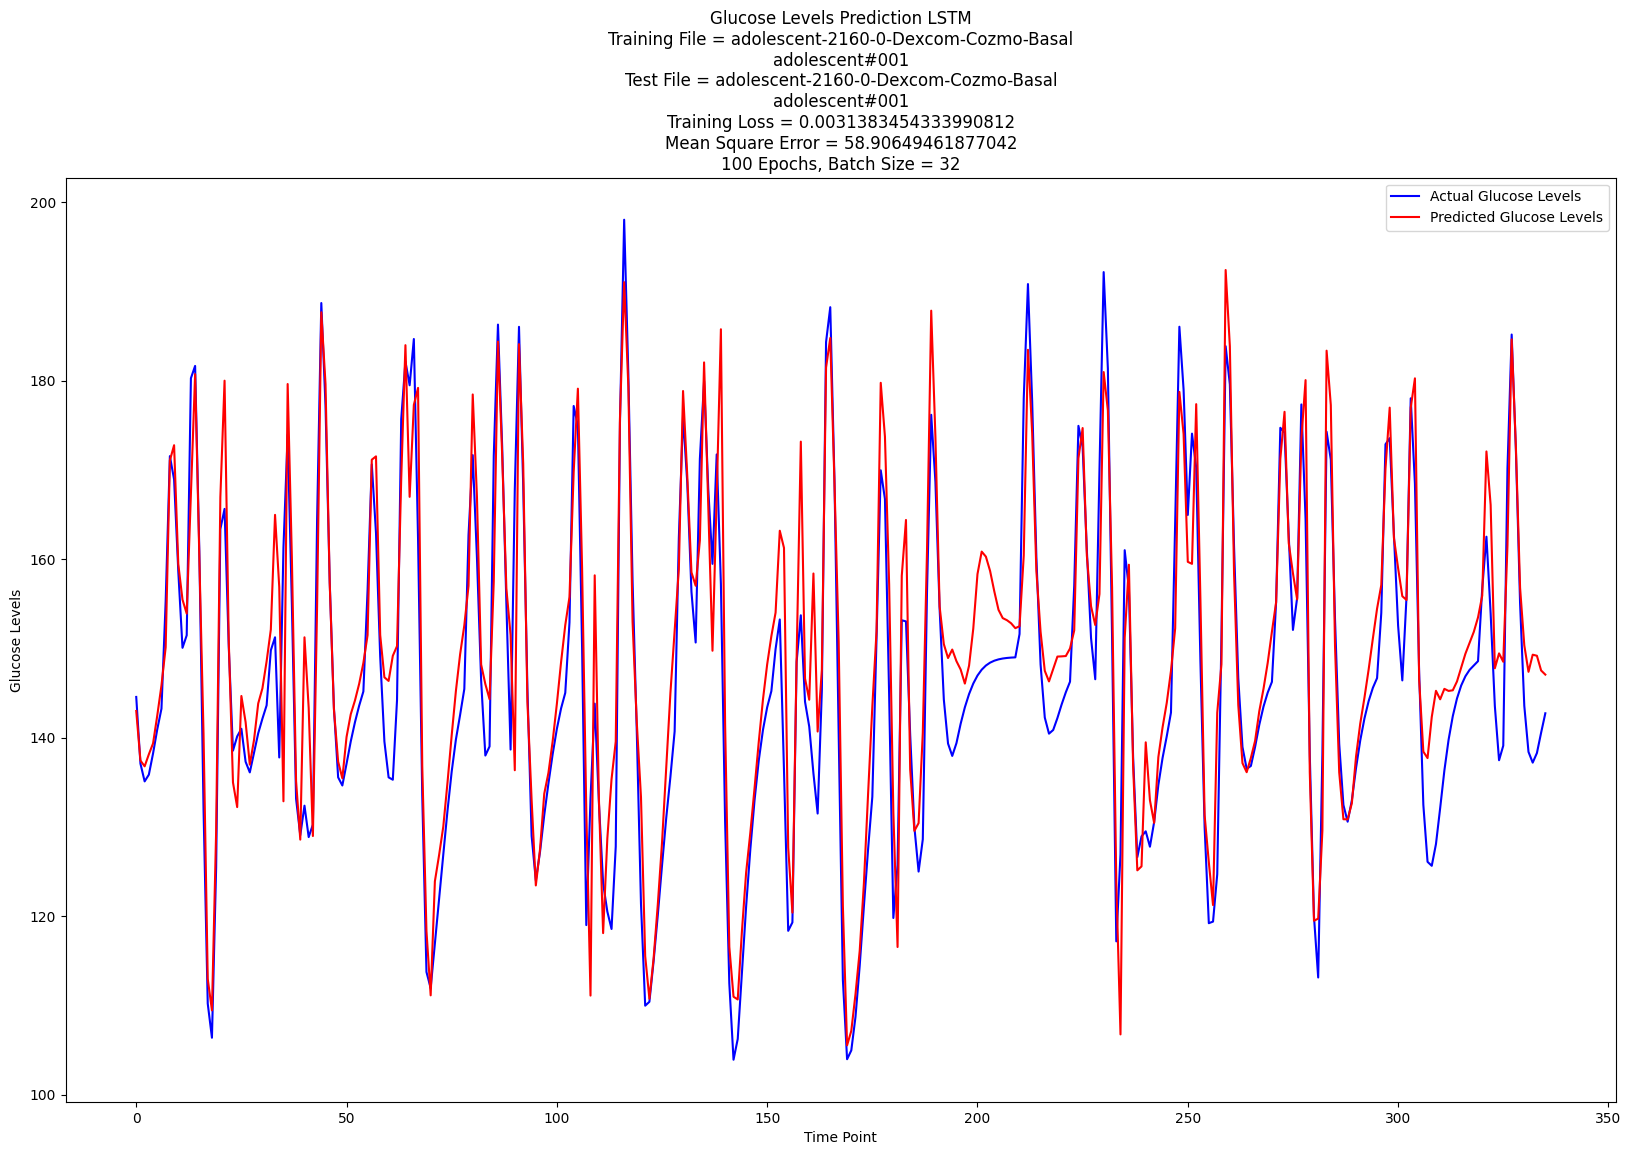

In [15]:
# Cell 16

#Plot predictions
print('\nBegin Part 19 of 19 - Plot predictions')

actual = test_glucose_df['Glucose_Level'].values
actual = actual[0:len(test_glucose_df)]



plot_data = 'Y' # Values are Y or N

print('\n\nPlotting predictions')
plt.figure(figsize=(20,12))
plt.plot(actual, color='blue', label='Actual Glucose Levels')
plt.plot(predictions , color='red', label='Predicted Glucose Levels')
plt.title('Glucose Levels Prediction LSTM\nTraining File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' + input_train_file_name_prefix
          + '\nTest File = adolescent-2160-0-Dexcom-Cozmo-Basal\n' + input_test_file_name_prefix + '\nTraining Loss = ' +
         str(loss) + '\nMean Square Error = ' + str(mean_square) + '\n' + str(num_epochs) + ' Epochs, ' +
         'Batch Size = ' + str(training_batch_size))
plt.xlabel('Time Point')
plt.ylabel('Glucose Levels')
plt.legend()
plt.show()





In [16]:
print('Training Loss = ' + str(loss))
print('Mean Square Error = ' + str(mean_square))

Training Loss = 0.0031383454333990812
Mean Square Error = 58.90649461877042
